# Разложение ошибки на смещение и разброс

Сохраните ваше решение в формате Name_Surname.ipynb, например Ivan_Ivanov.ipynb

Credits: [Евгений Соколов](https://github.com/esokolov)

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа

На лекции мы вывели форулу разложения на смещение и разброс:
если $y(x)=f(x)+\varepsilon$, где $x$-фиксированный объект, $\varepsilon$ - независимый от x и обучающей выборки $T = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$ случайный шум с нулевым средним, то для прогнозирующего алгоритма $a_T$, обученного на выборке $T$ справедливо:
$$\mathbb{E}_{T,\varepsilon}[(a_T(x)-y(x))^2]=\mathbb{E}_T (a_T(x)-\mathbb{E}_T a_T(x))^2+(f(x)-\mathbb{E}_T a_T(x))^2+\mathbb{E_{\varepsilon}}\varepsilon^2$$

Взяв мат. ожидание по всевозможным объектам $(x,y)$, получим:

$$
L(a) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{T}\bigl[ (y - a_T(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{T}\bigl[(a_T(x) - \mathbb{E}_{T}[a_T(x)] )^2\bigr]\bigr]}_{\text{разброс}} + 
    \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{T}[a_T(x)] - f(x) )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x, y}\bigl[\varepsilon^2\bigr]}_{\text{шум}},
$$
* $a(X)$ --- алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $a(X)(x)$ --- ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{T}$ --- мат. ожидание по всем возможным обучающим выборкам;
* $\mathbb{E}_{T}[a_T(x)]$ --- "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
  
  
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $a$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + a^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.145158559481104

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_T$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $T$, нам понадобится выборка из выборок:
$$\mathbb{E}_T f(T) \approx \frac 1 s \sum_{j=1}^s f(T_j),$$
где $T_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $T_j$ методом бутстрапа.
1. На каждой выборке $T_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $T_j$ определить множество объектов $O_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $O_j$ (чтобы предсказания считались для тех объектов, которые НЕ использовались в обучении соответствующего алгоритма). 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать $y=f(x)$, т.е. $\varepsilon\equiv 0$, и $f(x)$ полагается равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $O_j$ (т.е. $a_j$ не использовал этот объект в обучении). Для получения общего смещения выполнить усреденение смещений по всем объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $O_j$. Для получения общего разброса выполнить усреденение разбросов по всем объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм эмпирического расчета компонент вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

### 1.Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def bootstrap(N, dataset):
    idx = np.arange(dataset.shape[0])
    T = np.random.choice(idx, size=N)
    O = np.array(list(set(idx) - set(T)))
    return T, O

In [8]:
def compute_biase_variance(regressor, X, Y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_features]
    :param Y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    answers = []
    error = 0
    num_preds = 0
    
    for i in range(num_runs):
        T, O = bootstrap(X.shape[0]//2, X)
        regressor.fit(X[T], Y[T])
        answer = np.zeros_like(Y, dtype=np.float)
        answer[T] = np.nan
        answer[O] = regressor.predict(X[O])
        num_preds += len(O)
        error += np.sum((answer[O] - Y[O])**2)
        answers.append(copy(answer))
    
    answers = np.array(answers)
    non_zero = np.count_nonzero(~np.isnan(answers), axis=0)
    avg_pred = np.nansum(answers, axis=0) / non_zero
    bias = (avg_pred - Y)**2
    var = np.nanvar(answers, axis=0)
    error /= num_preds
    
    return np.mean(bias), np.mean(var), error

### 2.Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from copy import copy

In [10]:
clf = LinearRegression()
bias, var, error = compute_biase_variance(clf, X, y)
print(f'bias {bias}, variance: {var}, error: {error}')
print(f'bias + variance: {bias + var}, error: {error}')

bias 23.731598131930074, variance: 1.999259394340232, error: 25.71226559970637
bias + variance: 25.730857526270306, error: 25.71226559970637


In [11]:
lab_enc = preprocessing.LabelEncoder()
y_tree = lab_enc.fit_transform(y)

In [12]:
clf = DecisionTreeClassifier()
bias, var, error = compute_biase_variance(clf, X, y_tree)
print(f'bias {bias}, variance: {var}, error: {error}')
print(f'bias + variance: {bias + var}, error: {error}')

bias 517.3338420070444, variance: 1050.2880526114534, error: 1569.2348131412418
bias + variance: 1567.6218946184977, error: 1569.2348131412418


In [13]:
clf = RandomForestClassifier()
bias, var, error = compute_biase_variance(clf, X, y_tree)
print(f'bias {bias}, variance: {var}, error: {error}')
print(f'bias + variance: {bias + var}, error: {error}')

/usr/lib/python3.8/site-packages/sklearn/ensemble/forest.py:244: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  warn("The default value of n_estimators will change from "


bias 543.0857674096459, variance: 912.4010707516321, error: 1455.7581170841727
bias + variance: 1455.486838161278, error: 1455.7581170841727


### 3.Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__
Как и ожидалось, у линейной регрессии большое смещение, а у деревьев и случайного леса большой разброс. Так как у линейной регрессии жестко выбрана функция, а деревья сильно зависят от обучающей выборки.

### 4.Визуализация предсказаний базовых алгоритмов бэггинга

На лекции приводилась аналогия с игрой в дартс - визуализация прогнозов алгоритмов с разным смещением и разным разбросом, пытающихся попасть в "мишень". В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, Y. Получится две выборки: маленькая X_test, Y_test (выбранные тестовые объекты) и X_train, Y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, Y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [14]:
def plot_predictions(regressor, X, y, subplt, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test, other = bootstrap(num_test_objects, X)
    X_test = X[test]
    Y_test = y[test]
    X_train = X[other]
    Y_train = y[other]
    
    for i in range(num_runs):
        T, _ = bootstrap(len(X_train)//2, X_train)
        regressor.fit(X_train[T], Y_train[T])
        preds = regressor.predict(X_test)
        
        subplt.scatter(np.arange(num_test_objects), preds, color='red')
        

    subplt.scatter(np.arange(num_test_objects), Y_test, color='black')
    subplt.set_title(title)
    subplt.set(xlabel='test objects', ylabel='preds')

### 5.Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

/usr/lib/python3.8/site-packages/sklearn/ensemble/forest.py:244: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  warn("The default value of n_estimators will change from "


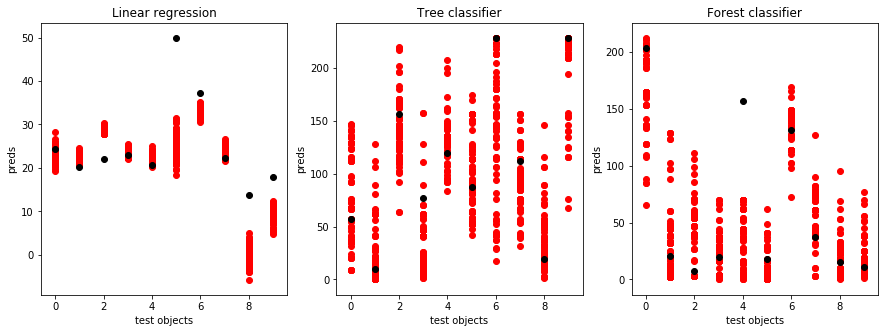

In [15]:
clf = LinearRegression()
clf_tree = DecisionTreeClassifier()
clf_forest = RandomForestClassifier()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_predictions(clf, X, y, ax[0], title="Linear regression")
plot_predictions(clf_tree, X, y_tree, ax[1], title="Tree classifier")
plot_predictions(clf_forest, X, y_tree, ax[2], title="Forest classifier")

### 6.Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Графики подтверждают предыдущий пункт: у логистической регрессии большой bias (черные точки не попадают на красные интервалы), а у деревьев и леса большой variance (красные интервалы очень размазаны).

# Изменение bias и variance при изменении гиперпараметров

### 7.Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [16]:
MAX_DEPTH = 10
calced_bias = np.zeros((MAX_DEPTH, X.shape[1]))
calced_var = np.zeros((MAX_DEPTH, X.shape[1]))

for max_depth in range(1, MAX_DEPTH + 1, 1):
    for max_feat in range(1, X.shape[1], 1):
        clf_tree = DecisionTreeClassifier(max_depth=max_depth, 
                                          max_features=max_feat)
        bias, var, _ = compute_biase_variance(clf_tree, X, y_tree)
        calced_bias[max_depth - 1, max_feat] = bias
        calced_var[max_depth - 1, max_feat] = var

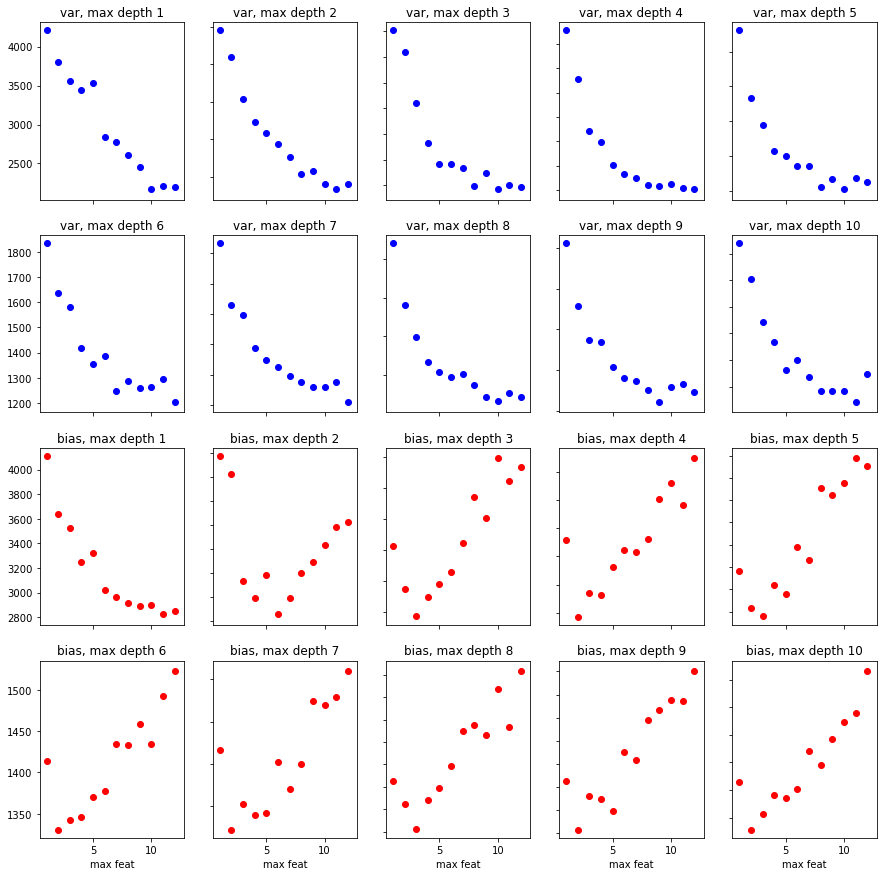

In [17]:
ROWS = 2
COLUMNS = MAX_DEPTH // ROWS
fig, axs = plt.subplots(ROWS * 2, COLUMNS, figsize=(15, 15))

for ax in axs.flat:
    ax.set(xlabel='max feat')
for ax in axs.flat:
    ax.label_outer()

for max_depth in range(1, MAX_DEPTH + 1, 1):
    for max_feat in range(1, X.shape[1], 1):
        bias = calced_bias[(max_depth - 1, max_feat)]
        var = calced_var[(max_depth - 1, max_feat)]
        ind_bias = (max_depth - 1) // COLUMNS + 2, (max_depth - 1) % COLUMNS
        ind_var = (max_depth - 1) // COLUMNS, (max_depth - 1) % COLUMNS
        subplt = axs[ind_var]
        subplt.scatter(max_feat, var, color='blue')
        subplt.set_title(f'var, max depth {max_depth}')
        
        subplt = axs[ind_bias]
        subplt.scatter(max_feat, bias, color='red')
        subplt.set_title(f'bias, max depth {max_depth}')
        #subplt.set(xlabel='max feat', ylabel='variance')

### 8.Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса:

In [18]:
calced_bias_forest = np.zeros(len(np.arange(1, 10)))
calced_var_forest = np.zeros(len(np.arange(1, 10)))


for i, n_estimators in enumerate(2**np.arange(1, 10)):
    clf = RandomForestClassifier(n_estimators=n_estimators)
    bias, var, _ = compute_biase_variance(clf, X, y_tree)
    calced_bias_forest[i] = bias
    calced_var_forest[i] = var

In [19]:
x_estimators = 2**np.arange(1, 10)

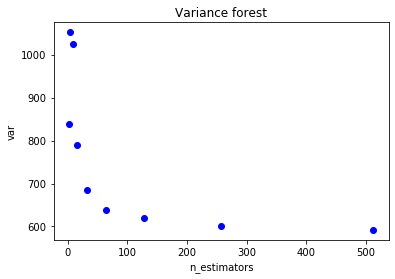

In [20]:
plt.scatter(x_estimators, calced_var_forest, color='blue')
plt.title("Variance forest")
plt.xlabel("n_estimators")
plt.ylabel("var")
plt.show()

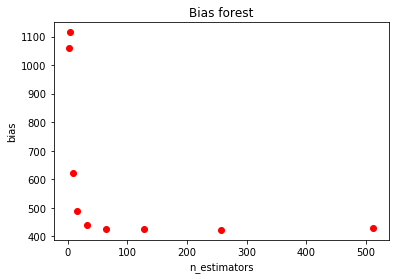

In [21]:
plt.scatter(x_estimators, calced_bias_forest, color='red')
plt.title("Bias forest")
plt.xlabel("n_estimators")
plt.ylabel("bias")
plt.show()

### 9.Прокомментируйте графики: почему они имеют такой вид.


При увеличении количества фичей дисперсия падает, а смещение растет, так как при увеличении количества фичей, модель больше подстраивается под данные.

С увеличением максимальной глубины дисперсия и смещение падают, хотя смещение должно увеличиваться (так как увеличивается сложность модели), это может быть незаметно из-за того, что нужно взять глубину больше.

С возрастанием деревьев в лесе смещение и дисперсия уменьшаются, потому что много независимых деревьев усредняются.